# Question 2 Jupyter Notebook - Troy Hall

# README

This analysis started with an overview of the data in Data Wrangler, an extension in VS Code that I've found very useful when attempting to quickly glean surface-level insights from a new dataset. From there, I broke down into deeper EDA and data correction/cleaning, creating some graphs illustrating some assumptions that I made about the distribution of the data.

I used DuckDB to write the SQL queries for this assignment, pulling from the cleaned dataset saved as "data_cleaned" within the Python environment when the user runs all chunks in this notebook.

A memo to an investment analyst is present at the bottom of this notebook, including some summarized insights from our SQL queries and notes about data cleaning procedures completed (and not completed).

# Imports

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import duckdb

# Load the dataset
data = pd.read_csv('crop_insurance_deals_2023_Problem2.csv')

# Display the first few rows of the dataset; checking for what the data looks like and to ensure it loaded correctly
data.head()

,CROP_YEAR,STATE_CODE,STATE_ABBR,COUNTY_CODE,COUNTY_NAME,CROP_CODE,CROP_NAME,INSURANCE_PLAN_CODE,INSURANCE_PLAN_NAME,STAGE_CODE,...,NET_REPORTED_QUANTITY,COMPANION_QUANTITY,LIABILITY,TOTAL_PREMIUM,PRODUCER_PREMIUM,SUBSIDY,STATE_SUBSIDY,ADDITIONAL_SUBSIDY,INDEMNITY,LOSS_RATIO
0,2023,18,IN,63,hendricks,81,Soybeans,4,AYP,A,...,528.0,0,357127.0,10392.0,5300,0,0,0,0,0.00
1,2023,31,NE,39,Cuming,41,Corn,2,RP,A,...,20767.0,0,18876035.0,1285088.0,802858,0,0,0,3905137,3.04
2,2023,48,TX,123,De Witt,11,wheat,2,RP,A,...,17.0,0,2697.0,616.0,363,0,0,0,-,0.00
3,2023,38,ND,59,Morton,11,Wheat,2,RP,A,...,97662.0,0,29098195.0,5956764.0,4416194,0,0,0,1002769,0.17
4,2023,39,OH,107,Mercer,81,Soybeans,88,ECO-RP,A,...,0.0,164,5806.0,2084.0,917,0,0,0,0,0.00


# Part 1: Data Cleaning

## Exploratory Data Analysis

Note - I used the Data Wrangler extension in VS Code to immediately check for missingness, column distributions, etc.
Noticed that:
- State code doesn't always match up with abbreviation (potential issues with county code)
- missing values are pretty sparse through the dataset
- almost all coverage values are in increments of 0.05
- state/additional subsidies are both 0 so not telling us anything
- numeric variable distributions have a long, LONG right tail. A few big rows pulling averages upward

### DF Shape, Types

In [226]:
# Check dataset shape to understand the number of rows and columns. 623 rows and 28 cols is a very manageable size, sticking with pandas for this analysis.
print(data.shape)
# Column Data Types (lots of objects, looks like these are mostly characters)
print(data.dtypes)

# quality of life improvement: making character columns all caps for easier searching and to prevent case sensitive issues.

# first, check if all object cols are character cols
char_cols = data.select_dtypes(include=['object']).columns
print(f'Object columns: {char_cols}') # all object cols are character cols

# make all character columns uppercase
data[char_cols] = data[char_cols].apply(lambda x: x.str.upper()) # used claude to speed this up

(623, 28)
CROP_YEAR                     int64
STATE_CODE                    int64
STATE_ABBR                   object
COUNTY_CODE                   int64
COUNTY_NAME                  object
CROP_CODE                     int64
CROP_NAME                    object
INSURANCE_PLAN_CODE           int64
INSURANCE_PLAN_NAME          object
STAGE_CODE                   object
COVERAGE_TYPE                object
COVERAGE_LEVEL              float64
POLICIES_SOLD                 int64
POLICIES_EARNING_PREMIUM      int64
POLICIES_INDEMNIFIED          int64
UNITS_EARNING_PREMIUM         int64
UNITS_INDEMNIFIED             int64
QUANTITY_TYPE                object
NET_REPORTED_QUANTITY       float64
COMPANION_QUANTITY            int64
LIABILITY                   float64
TOTAL_PREMIUM               float64
PRODUCER_PREMIUM              int64
SUBSIDY                       int64
STATE_SUBSIDY                 int64
ADDITIONAL_SUBSIDY            int64
INDEMNITY                    object
LOSS_RATIO        

In [227]:
# Summary statistics
data.describe() # data mostly from 2023, outliers in total premium and indemnity look like they could be legit based on the size of farms; checking outliers later

,CROP_YEAR,STATE_CODE,COUNTY_CODE,CROP_CODE,INSURANCE_PLAN_CODE,COVERAGE_LEVEL,POLICIES_SOLD,POLICIES_EARNING_PREMIUM,POLICIES_INDEMNIFIED,UNITS_EARNING_PREMIUM,UNITS_INDEMNIFIED,NET_REPORTED_QUANTITY,COMPANION_QUANTITY,LIABILITY,TOTAL_PREMIUM,PRODUCER_PREMIUM,SUBSIDY,STATE_SUBSIDY,ADDITIONAL_SUBSIDY,LOSS_RATIO
count,623.000000,623.000000,623.000000,623.000000,623.000000,618.000000,623.000000,623.000000,623.000000,623.000000,623.000000,619.000000,623.000000,6.120000e+02,6.130000e+02,6.230000e+02,623.000000,623.0,623.0,623.000000
mean,2023.000000,29.943820,111.004815,46.971108,13.064205,0.726942,36.059390,25.711075,11.341894,49.003210,19.772071,5668.562197,770.356340,4.222612e+06,6.558476e+07,2.084517e+05,101.898876,0.0,0.0,7.212103
std,0.126796,13.124376,88.949505,26.861185,23.033997,0.127968,84.662606,68.215895,35.415226,127.991283,62.636496,15921.556205,3484.758993,1.263539e+07,8.057837e+08,5.717441e+05,966.124301,0.0,0.0,79.884796
min,2022.000000,17.000000,1.000000,11.000000,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000e+05,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.000000
25%,2023.000000,19.000000,47.000000,21.000000,2.000000,0.650000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,7.070750e+03,7.150000e+02,4.575000e+02,0.000000,0.0,0.0,0.000000
50%,2023.000000,27.000000,97.000000,41.000000,2.000000,0.750000,4.000000,2.000000,1.000000,5.000000,1.000000,96.000000,0.000000,1.225180e+05,1.270100e+04,7.986000e+03,0.000000,0.0,0.0,0.020000
75%,2023.000000,39.000000,147.000000,81.000000,17.000000,0.800000,24.000000,13.000000,4.500000,32.500000,7.000000,1404.000000,0.000000,1.164047e+06,1.528900e+05,8.717450e+04,0.000000,0.0,0.0,1.110000
max,2024.000000,99.000000,493.000000,81.000000,89.000000,0.950000,1045.000000,915.000000,345.000000,1768.000000,686.000000,143605.000000,43116.000000,1.034472e+08,1.000000e+10,4.416194e+06,15666.000000,0.0,0.0,999.990000


### Missingness/dupes

In [228]:
# Check for missing values greater than 0 in each column
missing_values = data.isnull().sum()
print(f'Missing values per column:\n{missing_values[missing_values > 0]}') # 6 cols have missing values (11 or fewer); small enough number to consider dropping or imputing (choose based on time)

# Check for duplicates in the dataset
duplicates = data.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}') # 14 dupes, considering dropping them to avoid skewing analysis. Small enough number to manually investigate

# Display duplicate rows for manual investigation, ordering by all columns to see full duplicates together
duplicate_rows = data[data.duplicated(keep=False)].sort_values(by=data.columns.tolist()) # quick claude assist here
duplicate_rows

# highly unlikely that any of these duplicate rows are legitimate, dropping them
data = data.drop_duplicates()

Missing values per column:
COUNTY_NAME              10
CROP_NAME                 8
COVERAGE_LEVEL            5
NET_REPORTED_QUANTITY     4
LIABILITY                11
TOTAL_PREMIUM            10
dtype: int64
Number of duplicate rows: 14


In [229]:
# checking crop name categories
data['CROP_NAME'].value_counts()

# trim all spaces from CROP_NAME entries
data['CROP_NAME'] = data['CROP_NAME'].str.strip()

# change MAIZE to CORN for consistency with crosswalk
data['CROP_NAME'] = data['CROP_NAME'].replace('MAIZE', 'CORN')

# change SOY BEANS to SOYBEANS for consistency with crosswalk
data['CROP_NAME'] = data['CROP_NAME'].replace('SOY BEANS', 'SOYBEANS')

# re-check crop name categories after trimming spaces
data['CROP_NAME'].value_counts()

# create crosswalk dictionary
crop_crosswalk = {11: 'WHEAT', 21: 'COTTON', 41: 'CORN', 81: 'SOYBEANS'}

# map CROP_CODE to CROP_NAME using the crosswalk
data['CROP_NAME_FROM_CODE'] = data['CROP_CODE'].map(crop_crosswalk)

# drop old crop name column
data = data.drop(columns=['CROP_NAME'])

In [230]:
# dropping county name - assuming county code is sufficient and to avoid any issues with inconsistent naming or typos in county names.
# could crosswalk this if needed but not directly relevant to analysis and time is limited.
data = data.drop(columns=['COUNTY_NAME'])

# also, trimming spaces from state abbreviation column to ensure consistency
data['STATE_ABBR'] = data['STATE_ABBR'].str.strip()

Have to make a decision here based on time: going to look at the financial columns for 30 minutes then head for DuckDB to answer remaining questions.

### Financial Data Analysis (graphing outliers)

Text(0.5, 1.0, 'Distribution of Acres Insured')

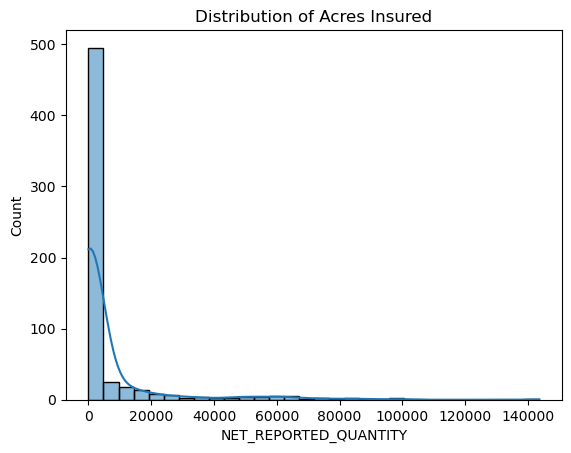

In [231]:
# first off - how many acres are captured in each county/crop/coverage type?
sns.histplot(data['NET_REPORTED_QUANTITY'], bins=30, kde=True)
plt.title('Distribution of Acres Insured') # LONG right tail, means outliers are going to have an outsized effect on data.

# Also means most financial data should follow this pattern of large acrages having large premiums and indemnities
# So will check outliers in those next to see if they align with the acreage outliers.

In [232]:
# net reported quantity equal to 0 might be a data entry error
zero_acres = data[data['NET_REPORTED_QUANTITY'] == 0]
print(f'Number of rows with zero acres: {len(zero_acres)}') # using claude to quickly report these f-strings

# significant proportion of dataset - likely not a data entry error. Not directly related to questions so skipping for now

Number of rows with zero acres: 242


Text(0.5, 1.0, 'Distribution of Insured Liability')

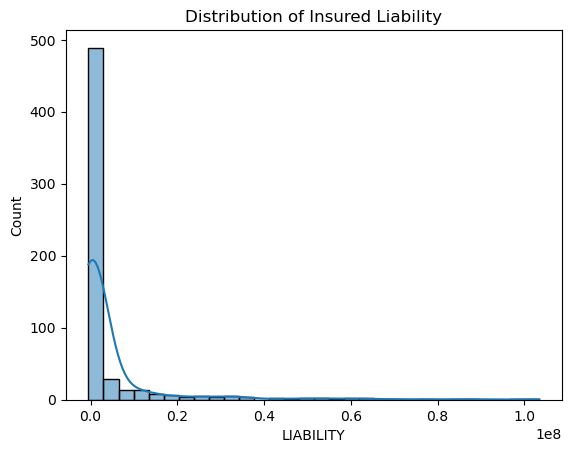

In [233]:
# starting with insured liability. looking at distribution and outliers.
sns.histplot(data['LIABILITY'], bins=30, kde=True)
plt.title('Distribution of Insured Liability')

Number of liability outliers: 30


Text(0.5, 1.0, 'Distribution of Acres Insured for Liability Outliers')

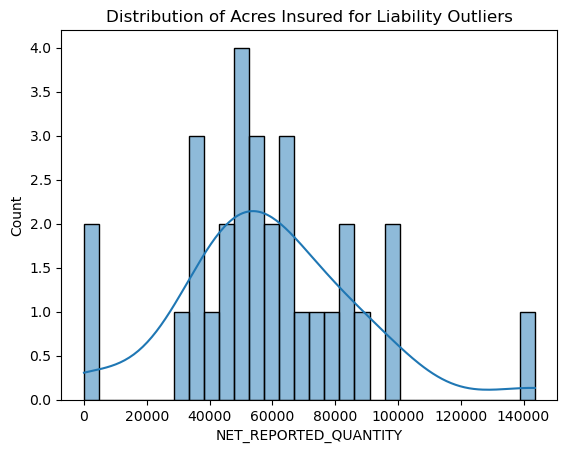

In [234]:
# checking liability outliers to see if they align with acreage outliers
liability_outliers = data[data['LIABILITY'] > data['LIABILITY'].quantile(0.95)] # top 5% of liability values
print(f'Number of liability outliers: {len(liability_outliers)}')

# checking if liability outliers align with acreage outliers by looking at the distribution of net reported quantity for the liability outliers
sns.histplot(liability_outliers['NET_REPORTED_QUANTITY'], bins=30, kde=True)
plt.title('Distribution of Acres Insured for Liability Outliers') # looks like the liability out

Number of liability majority rows: 568


Text(0.5, 1.0, 'Distribution of Acres Insured for Liability Majority')

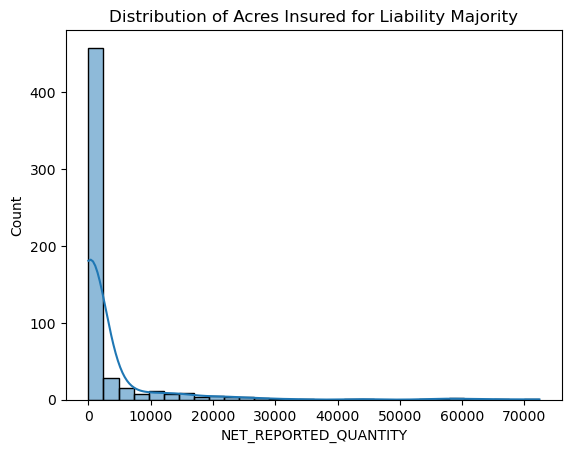

In [235]:
# now, looking at liability majority to see if it aligns with acerage majority
liability_majority = data[data['LIABILITY'] <= data['LIABILITY'].quantile(0.95)] # bottom 95% of liability values
print(f'Number of liability majority rows: {len(liability_majority)}')

sns.histplot(liability_majority['NET_REPORTED_QUANTITY'], bins=30, kde=True)
plt.title('Distribution of Acres Insured for Liability Majority') # looks like the liability majority has

Main takeaway from all these graphs - our acres insured are right skewed, so we'd expect a right skew in the rest of our financial data. Need to minimize missingness or strange values in indemnity payments, loss ratio, and policy data to get to SQL analysis.

In addition - acrage here for many of our county/crop/coverage level policy rows is at zero (242 rows have no acres reported). This might be because some acres were not planted due to covered causes or other factors, but it's something that I would certainly flag to the investment team.

It is also possible that this is to be expected, and my personal inexperience with agricultural data caused me to flag this.

Some liabilities also have negative values - it appears this could be expected, but it's something else to watch as a data quality issue.

### Indemnity and Loss Ratio Correction

Completing these tasks before moving on, necessary for somewhat accurate SQL queries.

In [236]:
# indemnity is an object - needs to be numeric. claude assist to convert indemnity to numeric, coercing errors to NaN (which will be checked for and handled in the next step)
data['INDEMNITY'] = pd.to_numeric(data['INDEMNITY'], errors='coerce')

# loss ratio column has some outliers of 999.99; since loss ratio is indemnity/total premium, unlikely that this is the case.
data['NEW_LOSS_RATIO'] = data['INDEMNITY'] / data['TOTAL_PREMIUM']

# if new loss ratio is missing, replace with old loss ratio (since new loss ratio is more accurate, but if indemnity or total premium is missing, will have to use old loss ratio)
data['NEW_LOSS_RATIO'] = data['NEW_LOSS_RATIO'].fillna(data['LOSS_RATIO'])

# check where new loss ratio is different from old loss ratio
data['LOSS_RATIO_DIFFERENCE'] = data['NEW_LOSS_RATIO'] - data['LOSS_RATIO']
loss_ratio_discrepancies = data[data['LOSS_RATIO_DIFFERENCE'].abs() > 0.01] # checking for discrepancies greater than 0.01
print(f'Number of rows with loss ratio discrepancies: {len(loss_ratio_discrepancies)}')

# using new loss ratio going forward, more accurate
data = data.drop(columns=['LOSS_RATIO'])

Number of rows with loss ratio discrepancies: 6


In [237]:
# time crunch means I won't be able to investigate other missing values or outliers.
# other issues included a couple of all 9 total premium values, some other missing values, and outlier analysis on the unit/policy counts.

# to ensure the missing values and outliers don't skew analysis, will be dropping rows with missing values and outliers for the analysis portion.
data_cleaned = data.dropna() # dropping rows with missing values
data_cleaned = data_cleaned[data_cleaned['LIABILITY'] <= data_cleaned['LIABILITY'].quantile(0.98)] # dropping liability outliers

# in a real scenario, would want to fully investigate these - just need more time on the data pipeline in Q1.

print(f'Original data shape: {data.shape}')
print(f'Cleaned data shape: {data_cleaned.shape}') # lost 46 rows or 7% of data, not ideal but given time constraints we need clean queries.

Original data shape: (609, 28)
Cleaned data shape: (563, 28)


In [238]:
data_cleaned.to_csv('crop_insurance_deals_2023_Problem2_cleaned.csv', index=False)

# Part 2: SQL Analysis

## DuckDB Queries

In [239]:
# Top 5 highest total insured liability in 2023
duckdb.query("""
SELECT state_abbr, SUM(LIABILITY) AS TOTAL_LIABILITY
from data_cleaned
where crop_year = 2023
group by state_abbr
ORDER BY TOTAL_LIABILITY DESC
LIMIT 5
""")

# Iowa, Illinois, Nebraska, South Dakota, Minnesota

┌────────────┬─────────────────┐
│ STATE_ABBR │ TOTAL_LIABILITY │
│  varchar   │     double      │
├────────────┼─────────────────┤
│ IA         │     286012240.0 │
│ IL         │     274179985.0 │
│ NE         │     164299276.0 │
│ SD         │     162158771.0 │
│ MN         │     149873479.0 │
└────────────┴─────────────────┘

In [240]:
# Avg loss ratio by crop type
duckdb.query("""
SELECT CROP_NAME_FROM_CODE as CROP, AVG(NEW_LOSS_RATIO) AS AVG_LOSS_RATIO
from data_cleaned
group by CROP
ORDER BY AVG_LOSS_RATIO DESC
""")

# Avg loss ratio displayed below - appears that cotton has the worst loss ratio (above 1 here).

┌──────────┬────────────────────┐
│   CROP   │   AVG_LOSS_RATIO   │
│ varchar  │       double       │
├──────────┼────────────────────┤
│ COTTON   │ 1.6440372146752855 │
│ SOYBEANS │ 0.8471191547584818 │
│ WHEAT    │ 0.6978797835057079 │
│ CORN     │ 0.6244939459384832 │
└──────────┴────────────────────┘

In [241]:
# for corn, top 10 counties with highest total indemnity payments
duckdb.query("""
SELECT state_abbr, COUNTY_CODE, SUM(INDEMNITY) AS TOTAL_INDEMNITY
from data_cleaned
where CROP_NAME_FROM_CODE = 'CORN'
group by state_abbr, COUNTY_CODE
ORDER BY TOTAL_INDEMNITY DESC
LIMIT 10
""") # have to group by state abbr and county code since some states use the same county code

# decided to group by state abbr for readability - would want to use code if this were real for accuracy

# top 10 counties listed below. Diverse states represented

┌────────────┬─────────────┬─────────────────┐
│ STATE_ABBR │ COUNTY_CODE │ TOTAL_INDEMNITY │
│  varchar   │    int64    │     double      │
├────────────┼─────────────┼─────────────────┤
│ KS         │          63 │       6801972.0 │
│ NE         │          39 │       3905137.0 │
│ IL         │         167 │       3834958.0 │
│ SD         │          99 │       3622969.0 │
│ SD         │         109 │       3306818.0 │
│ KS         │          15 │       2403725.0 │
│ IL         │         203 │       1407115.0 │
│ MN         │         139 │       1361754.0 │
│ ND         │          55 │       1274695.0 │
│ SD         │          11 │       1268766.0 │
├────────────┴─────────────┴─────────────────┤
│ 10 rows                          3 columns │
└────────────────────────────────────────────┘

In [242]:
# what % of policies resulted in a claim by state? Rank from highest to lowest.
# using policies sold as denominator, policies indemnified as numerator
duckdb.query("""
SELECT state_abbr, sum(policies_sold) AS POLICIES_SOLD, sum(policies_indemnified) AS POLICIES_INDEMNIFIED, (sum(policies_indemnified) / sum(policies_sold)) AS CLAIM_RATE
from data_cleaned
group by state_abbr
ORDER BY CLAIM_RATE DESC
""")

# Nebraska had a rough year, while OH had a similar number of claims with a much lower claim rate.

┌────────────┬───────────────┬──────────────────────┬─────────────────────┐
│ STATE_ABBR │ POLICIES_SOLD │ POLICIES_INDEMNIFIED │     CLAIM_RATE      │
│  varchar   │    int128     │        int128        │       double        │
├────────────┼───────────────┼──────────────────────┼─────────────────────┤
│ NE         │          1524 │                  553 │ 0.36286089238845143 │
│ SD         │           937 │                  337 │ 0.35965848452508004 │
│ MN         │          1106 │                  375 │ 0.33905967450271246 │
│ KS         │          2422 │                  812 │  0.3352601156069364 │
│ TX         │          1391 │                  370 │ 0.26599568655643424 │
│ IL         │          2580 │                  631 │ 0.24457364341085272 │
│ IA         │          2758 │                  614 │  0.2226250906453952 │
│ ND         │          1194 │                  233 │ 0.19514237855946398 │
│ IN         │           784 │                   80 │ 0.10204081632653061 │
│ OH        

# Memo for End User

This data comes from the USDA's RMA Summary of Business database, organized with each row representing crop insurance policies at the county/crop/coverage area - almost all information in this database is from crop year 2023.

The extraction process resulted in a few data quality issues. Those identified and fixed included:
- Inconsistent capitalization and whitespace among text data
- Inconsistent crop naming conventions and missing names
- Duplicated rows
- Missing and inaccurate loss ratio information

Due to time constraints, some issues were either addressed with swift fixes or remain in the dataset. These include, but are not limited to:
- Removal of rows with missing values after initial analysis
- Upper bound outliers for liability values (appeared to be data entry issues based on available info)

The data team will seek to improve imputation and flagging procedures in the future.

Initial insights from our cleaning exercise and initial analysis include the following:
- OH and IN appear to each have a low loss ratio for their claim number, while the northwestern Midwest in SD, MN, and NE appears to have experienced high claim rates in 2023.
- KS and SD both appear to have 5 of the top 10 counties in the country by total claims paid; however, SD also ranks in the top 5 states in the country by total liability. Between the high claim rates and large exposure, that region of the country likely requires greater scrutiny.
- ND did not experience the same high claim rate as SD, despite neighboring to the north. It is possible that any losses were due to a localized weather event or other state-specific phenomena.

This analysis is limited by our reliance on 2023 data - while a negligible number of 2024/2022 claims are available, this analysis largely relies on data from the past in a single year. We also do not know what months claims were made and losses were realized. We cannot draw conclusions across years or make any assumptions around seasonality as a result.

We also are limited by the removal of rows with missing values after initial analysis - the data team will seek to come up with reasonable imputation methods to deal with missing data in the future. Mean imputation or other simple methods were not pursued here to ensure data integrity.